In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import rasterio
from tensorflow import keras
from keras.layers import ConvLSTM2D,BatchNormalization,Conv2D,Reshape,Conv3D,MaxPooling2D,MaxPooling3D,Flatten,Dense,RepeatVector,TimeDistributed
from keras.utils import img_to_array
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

In [14]:
#open the image stack
with rasterio.open("C:/Users/Richard Omondi/Downloads/phlipines cropped/cagayan_precip_cropped.tif") as src:
    #Read the image data
    image = src.read()

In [3]:
#Print image
image

array([[[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        ...,
        [       nan,        nan,        nan, ..., 0.        ,
                nan,        nan],
        [       nan,        nan,        nan, ..., 0.        ,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        ...,
        [       nan,        nan,        nan, ..., 0.        ,
                nan,        nan],
        [   

In [4]:
# check shape of the image
image.shape

(6510, 32, 15)

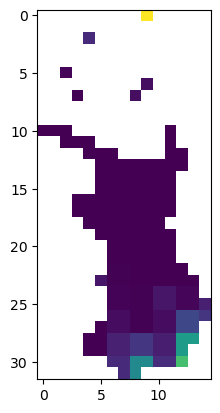

In [5]:
#Visualize a single band in image
plt.imshow(image[6210])

In [38]:
#Mask the NaN values
# Fill NaN values with zero
image[np.isnan(image)] = -1

# Check the modified image
print(image)

[[[-1.         -1.         -1.         ... -1.         -1.
   -1.        ]
  [-1.         -1.         -1.         ... -1.         -1.
   -1.        ]
  [-1.         -1.         -1.         ... -1.         -1.
   -1.        ]
  ...
  [-1.         -1.         -1.         ...  0.         -1.
   -1.        ]
  [-1.         -1.         -1.         ...  0.         -1.
   -1.        ]
  [-1.         -1.         -1.         ... -1.         -1.
   -1.        ]]

 [[-1.         -1.         -1.         ... -1.         -1.
   -1.        ]
  [-1.         -1.         -1.         ... -1.         -1.
   -1.        ]
  [-1.         -1.         -1.         ... -1.         -1.
   -1.        ]
  ...
  [-1.         -1.         -1.         ...  0.         -1.
   -1.        ]
  [-1.         -1.         -1.         ...  0.01625822 -1.
   -1.        ]
  [-1.         -1.         -1.         ... -1.         -1.
   -1.        ]]

 [[-1.         -1.         -1.         ... -1.         -1.
   -1.        ]
  [-1.   

In [39]:
#Check if there are nan values
np.count_nonzero(np.isnan(image))

0

In [40]:
#Create an input sequence function with a sequence length of 5
sequence_length = 5

# create a sequence for the images
def stack_images_to_seq(image, sequence_length):
    num_images = image.shape[0]
    sequences=[]
    
    for i in range(num_images-sequence_length + 1):
        sequence = image[i:i+sequence_length]
        sequences.append(sequence)
    return np.array(sequences)

In [41]:
#Apply the input sequence function to the image
sequences = stack_images_to_seq(image,sequence_length)

In [43]:
#Check the shape of nthe sequence
sequences.shape

(6506, 5, 32, 15)

In [ ]:
#Normalize the images ,we use 255 sinece it's an image
sequences = sequences/255

In [44]:
#Split the data into training and testing set
from sklearn.model_selection import train_test_split
#0.0462365591397849462
# Split sequences into X and y
X = sequences[:,:-1]  # Input sequences
y = sequences[:,1]   # Output sequence

# Split the data into training and testing sets/2021
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Print the shapes of the split sets
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)


X_train shape: (5204, 4, 32, 15)
y_train shape: (5204, 32, 15)
X_test shape: (1302, 4, 32, 15)
y_test shape: (1302, 32, 15)


In [29]:
# Preprocess the training and test data
X_train_processed = X_train.reshape((X_train.shape[0], 1, X_train.shape[1], X_train.shape[2], X_train.shape[3]))
X_test_processed = X_test.reshape((X_test.shape[0], 1, X_test.shape[1], X_test.shape[2], X_test.shape[3]))

In [31]:
X_test_processed.shape

(1302, 1, 4, 32, 15)

In [45]:
from keras.models import Sequential
from keras.layers import Conv2D, LSTM, TimeDistributed, Flatten, Dense
from keras.regularizers import l2

# Define 2D CNN-LSTM model
model = Sequential()
model.add(TimeDistributed(Conv2D(64, (3, 3), activation='relu'), input_shape=(1,4, 32, 15)))
model.add(TimeDistributed(Conv2D(64, (1, 1), activation='relu')))
model.add(TimeDistributed(Flatten()))
model.add(LSTM(150))
model.add(Dense(32*15, activation='relu'))
model.add(Reshape((32, 15)))
model.compile(loss='mse', optimizer='adam')
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_3 (TimeDis  (None, 1, 2, 30, 64)     8704      
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 1, 2, 30, 64)     4160      
 tributed)                                                       
                                                                 
 time_distributed_5 (TimeDis  (None, 1, 3840)          0         
 tributed)                                                       
                                                                 
 lstm_1 (LSTM)               (None, 150)               2394600   
                                                                 
 dense_1 (Dense)             (None, 480)               72480     
                                                      

In [47]:
# Fit the model with the preprocessed data
model.fit(X_train_processed, y_train, batch_size=4, validation_data=(X_test_processed, y_test), epochs=400)

Epoch 1/10



KeyboardInterrupt



In [39]:
#RMSE test
import numpy as np
from sklearn.metrics import mean_squared_error

# Assuming you have already trained the model and obtained predictions
X_pred = model.predict(X_test_processed)
X_pred1= model.predict(X_train_processed)
# Reshape the predictions and ground truth to match the original shape
X_pred = X_pred.reshape((X_pred.shape[0],X_pred.shape[1]*X_pred.shape[2]))
X_pred1 = X_pred1.reshape((X_pred1.shape[0],X_pred1.shape[1]*X_pred1.shape[2]))
y_test_original = y_test.reshape((y_test.shape[0], y_test.shape[1]*y_test.shape[2]))
y_train_original = y_train.reshape((y_train.shape[0], y_train.shape[1]*y_train.shape[2]))

# Calculate RMSE
mse1= mean_squared_error(y_train_original,X_pred1)
mse = mean_squared_error(y_test_original, X_pred)
rmse = np.sqrt(mse)
rmse1= np.sqrt(mse1)
print("Test Root Mean Squared Error (RMSE):", rmse*255)
print("Train Root Mean Squared Error (RMSE):",rmse1*255)

163/163 [==============================] - 2s 9ms/step
Test Root Mean Squared Error (RMSE): 1.905239496845752
Train Root Mean Squared Error (RMSE): 0.9310001553967595


In [41]:
#Check the shape of the X_pred
X_pred.shape

(1302, 480)

In [42]:
# Reshape X_pred and y_test_original to match the original image dimensions
height = 32
width = 15
X_pred_reshaped = X_pred.reshape(-1, height, width)
y_test_original_reshaped = y_test_original.reshape(-1, height, width)

In [43]:
#Recheck the shape
X_pred_reshaped.shape

(1302, 32, 15)

In [ ]:
# Visualize the images of the predicted and actual images
plt.figure()
plt.title('Predicted Image')
plt.imshow(X_pred_reshaped[1])
plt.axis('off')
plt.show()

plt.figure()
plt.title('Real Image')
plt.imshow(y_test[1])
plt.axis('off')
plt.show()

In [46]:
y_test[1]*255

array([[-1.00000000e+00, -1.00000000e+00, -1.00000000e+00,
        -1.00000000e+00, -1.00000000e+00, -1.00000000e+00,
        -1.00000000e+00, -1.00000000e+00, -1.00000000e+00,
         2.91662291e-03, -1.00000000e+00, -1.00000000e+00,
        -1.00000000e+00, -1.00000000e+00, -1.00000000e+00],
       [-1.00000000e+00, -1.00000000e+00, -1.00000000e+00,
        -1.00000000e+00, -1.00000000e+00, -1.00000000e+00,
        -1.00000000e+00, -1.00000000e+00, -1.00000000e+00,
        -1.00000000e+00, -1.00000000e+00, -1.00000000e+00,
        -1.00000000e+00, -1.00000000e+00, -1.00000000e+00],
       [-1.00000000e+00, -1.00000000e+00, -1.00000000e+00,
        -1.00000000e+00,  2.53091268e-02, -1.00000000e+00,
        -1.00000000e+00, -1.00000000e+00, -1.00000000e+00,
        -1.00000000e+00, -1.00000000e+00, -1.00000000e+00,
        -1.00000000e+00, -1.00000000e+00, -1.00000000e+00],
       [-1.00000000e+00, -1.00000000e+00, -1.00000000e+00,
        -1.00000000e+00, -1.00000000e+00, -1.00000000

In [49]:
X_test.shape

(1302, 4, 32, 15)

In [50]:
#predict future images for the years 2022-2023
import numpy as np


num_predictions = 795  # Number of future predictions desired
prediction_seq = np.copy(X_test)

for _ in range(num_predictions):
    next_image = model.predict(prediction_seq[:, -4:, :, :]) 
    next_image = np.expand_dims(next_image, axis=1)
    next_image = np.tile(next_image, (1, 4, 1, 1))
    prediction_seq = np.concatenate((prediction_seq, next_image), axis=1)

future_images = prediction_seq[-num_predictions:, -4:, :, :]

print("Predicted future images shape:", future_images.shape)


41/41 [==============================] - 1s 11ms/step
Predicted future images shape: (795, 4, 32, 15)


In [51]:
future_images[708]*255

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]], dtyp

In [ ]:
#Visualize a single image of future images
plt.imshow(future_images[46,0,:,:])

In [ ]:
###THE END OF NOTEBOOK

In [108]:
future_images.shape

(795, 4, 12, 9)

In [30]:
import numpy as np

# Define the number of future predictions
num_predictions = 795

# Create a copy of the input sequence for making predictions
prediction_seq = np.copy(X_test)

# Generate future predictions
for _ in range(num_predictions):
    # Predict the next image in the sequence
    next_image = model.predict(prediction_seq[:, -4:, :, :])  # Assuming sequence_length = 4
    next_image = np.expand_dims(next_image, axis=1)

    # Tile next_image to match the sequence length of prediction_seq
    next_image = np.tile(next_image, (1, 4 , 1, 1))  # Assuming sequence_length = 4

    # Append the predicted image to the prediction sequence
    prediction_seq = np.concatenate((prediction_seq, next_image), axis=1)

# Extract the predicted future images
future_images = prediction_seq[-num_predictions:, -4:, :, :] 

# Reshape the predicted images to match the original shape
future_images = np.reshape(future_images, (num_predictions, 4, 32, 15))  # Assuming sequence_length = 4

# Print the shape of the predicted future images
print("Predicted future images shape:", future_images.shape)


41/41 [==============================] - 0s 6ms/step
Predicted future images shape: (795, 4, 32, 15)


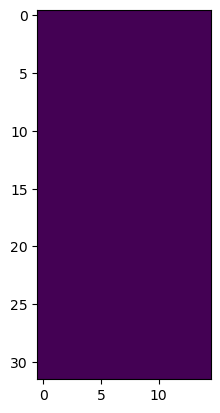

In [65]:
plt.imshow(future_images[692,0,:,:], label='predicted')

In [86]:
np.amax(future_images,axis=(1,2))

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.2689274 , 0.26881567, 0.16961347, ..., 0.6581588 , 0.65813726,
        0.31774017],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.13105947, 0.13113567, 0.30502048, ..., 0.37620848, 0.3761824 ,
        0.17850482]], dtype=float32)

In [88]:
future_images*255

array([[[[ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
           0.      ],
         [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
           0.      ],
         [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
           0.      ],
         ...,
         [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
           0.      ],
         [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
           0.      ],
         [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
           0.      ]],

        [[ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
           0.      ],
         [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
           0.      ],
         [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
           0.      ],
         ...,
         [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
           0.      ],
         [ 0.      ,  0.      ,  0.      , ...,  0

In [109]:
np.amax(image,axis=(1,2))

array([ 0.0925686 ,  0.12029542,  0.05285657, ..., 45.96876   ,
        4.136689  ,  0.39478835], dtype=float32)

In [95]:
def unstack_seq_to_images(sequences):
    num_sequences = sequences.shape[0]
    sequence_length = sequences.shape[1]
    image_height = sequences.shape[2]
    image_width = sequences.shape[3]
    
    images = np.reshape(sequences, (num_sequences * sequence_length, image_height, image_width))
    images = images[:num_sequences + sequence_length-1]  # Select only the original number of images
    
    return images

In [100]:
reconstructed_images = unstack_seq_to_images(future_images)
print(reconstructed_images.shape)

(798, 32, 15)


In [103]:
np.amax(reconstructed_images*28, axis=(1,2))

array([ 0.      ,  0.      ,  0.      ,  0.      , 18.516891, 18.516891,
       18.516891, 18.516891,  0.      ,  0.      ,  0.      ,  0.      ,
        4.984785,  4.984785,  4.984785,  4.984785,  0.      ,  0.      ,
        0.      ,  0.      , 17.89579 , 17.89579 , 17.89579 , 17.89579 ,
        0.      ,  0.      ,  0.      ,  0.      ,  0.      ,  0.      ,
        0.      ,  0.      , 17.895767, 17.895767, 17.895767, 17.895767,
        0.      ,  0.      ,  0.      ,  0.      ,  0.      ,  0.      ,
        0.      ,  0.      ,  0.      ,  0.      ,  0.      ,  0.      ,
        0.      ,  0.      ,  0.      ,  0.      ,  0.      ,  0.      ,
        0.      ,  0.      ,  0.      ,  0.      ,  0.      ,  0.      ,
        0.      ,  0.      ,  0.      ,  0.      ,  4.427009,  4.427009,
        4.427009,  4.427009,  0.      ,  0.      ,  0.      ,  0.      ,
        0.      ,  0.      ,  0.      ,  0.      ,  0.      ,  0.      ,
        0.      ,  0.      ,  0.      ,  0.      , 

In [110]:
np.max(reconstructed_images*28,axis=(1,2))

array([ 0.      ,  0.      ,  0.      ,  0.      , 18.516891, 18.516891,
       18.516891, 18.516891,  0.      ,  0.      ,  0.      ,  0.      ,
        4.984785,  4.984785,  4.984785,  4.984785,  0.      ,  0.      ,
        0.      ,  0.      , 17.89579 , 17.89579 , 17.89579 , 17.89579 ,
        0.      ,  0.      ,  0.      ,  0.      ,  0.      ,  0.      ,
        0.      ,  0.      , 17.895767, 17.895767, 17.895767, 17.895767,
        0.      ,  0.      ,  0.      ,  0.      ,  0.      ,  0.      ,
        0.      ,  0.      ,  0.      ,  0.      ,  0.      ,  0.      ,
        0.      ,  0.      ,  0.      ,  0.      ,  0.      ,  0.      ,
        0.      ,  0.      ,  0.      ,  0.      ,  0.      ,  0.      ,
        0.      ,  0.      ,  0.      ,  0.      ,  4.427009,  4.427009,
        4.427009,  4.427009,  0.      ,  0.      ,  0.      ,  0.      ,
        0.      ,  0.      ,  0.      ,  0.      ,  0.      ,  0.      ,
        0.      ,  0.      ,  0.      ,  0.      , 

In [111]:
reconstructed_images=reconstructed_images*28

In [113]:
np.amax(reconstructed_images,axis=(1,2))

array([ 0.      ,  0.      ,  0.      ,  0.      , 18.516891, 18.516891,
       18.516891, 18.516891,  0.      ,  0.      ,  0.      ,  0.      ,
        4.984785,  4.984785,  4.984785,  4.984785,  0.      ,  0.      ,
        0.      ,  0.      , 17.89579 , 17.89579 , 17.89579 , 17.89579 ,
        0.      ,  0.      ,  0.      ,  0.      ,  0.      ,  0.      ,
        0.      ,  0.      , 17.895767, 17.895767, 17.895767, 17.895767,
        0.      ,  0.      ,  0.      ,  0.      ,  0.      ,  0.      ,
        0.      ,  0.      ,  0.      ,  0.      ,  0.      ,  0.      ,
        0.      ,  0.      ,  0.      ,  0.      ,  0.      ,  0.      ,
        0.      ,  0.      ,  0.      ,  0.      ,  0.      ,  0.      ,
        0.      ,  0.      ,  0.      ,  0.      ,  4.427009,  4.427009,
        4.427009,  4.427009,  0.      ,  0.      ,  0.      ,  0.      ,
        0.      ,  0.      ,  0.      ,  0.      ,  0.      ,  0.      ,
        0.      ,  0.      ,  0.      ,  0.      , 

In [190]:
np.max(image7898, axis=(1,2))

array([39.34407  , 39.34407  , 39.34407  , 39.34407  , 39.34408  ,
       39.34408  , 39.34408  , 39.34408  , 39.34409  , 39.34409  ,
       39.34409  , 39.34409  , 39.344063 , 39.344063 , 39.344063 ,
       39.344063 , 39.344055 , 39.344055 , 39.344055 , 39.344055 ,
       39.344063 , 39.344063 , 39.344063 , 39.344063 , 14.481675 ,
       14.481675 , 14.481675 , 14.481675 , 39.344086 , 39.344086 ,
       39.344086 , 39.344086 , 39.344086 , 39.344086 , 39.344086 ,
       39.344086 , 39.344078 , 39.344078 , 39.344078 , 39.344078 ,
       39.34408  , 39.34408  , 39.34408  , 39.34408  , 26.537895 ,
       26.537895 , 26.537895 , 26.537895 , 39.34407  , 39.34407  ,
       39.34407  , 39.34407  , 23.43502  , 23.43502  , 23.43502  ,
       23.43502  , 39.344078 , 39.344078 , 39.344078 , 39.344078 ,
       39.344086 , 39.344086 , 39.344086 , 39.344086 , 39.344078 ,
       39.344078 , 39.344078 , 39.344078 , 39.34408  , 39.34408  ,
       39.34408  , 39.34408  , 39.34409  , 39.34409  , 39.3440

In [279]:
image7898 = image7898*32

In [281]:
image7898.shape

(798, 32, 15)

In [282]:
import rasterio
import numpy as np

# Assuming you have a 3-dimensional NumPy array called 'image7898' with shape (bands, height, width)

# Define the metadata for the output GeoTIFF file
meta = {
    'width': image7898.shape[2],
    'height': image7898.shape[1],
    'count': image7898.shape[0],  # number of bands in the image
    'dtype': image7898.dtype,
    'driver': 'GTiff',
    'crs': '+proj=longlat +datum=WGS84 +no_defs',
    'transform': rasterio.Affine.identity(),
}

# Create a new GeoTIFF file and write the image data
with rasterio.open('Cagayana1.tif', 'w', **meta) as dst:
    for band in range(image7898.shape[0]):
        dst.write(image7898[band, :, :], band + 1)


c:\Users\Richard Omondi\anaconda3\lib\site-packages\rasterio\__init__.py:331: NotGeoreferencedWarning: The given matrix is equal to Affine.identity or its flipped counterpart. GDAL may ignore this matrix and save no geotransform without raising an error. This behavior is somewhat driver-specific.
  dataset = writer(


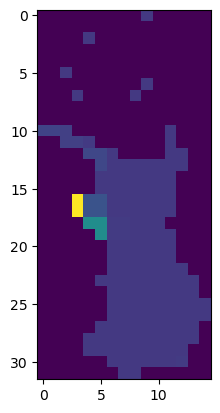

In [276]:
plt.imshow(image[110])

In [283]:
import rasterio
import numpy as np

# Assuming you have a NumPy array called 'image7898' containing the masked image data

# Define the metadata for the output GeoTIFF file
meta = {
    'driver': 'GTiff',
    'height': image7898.shape[1],
    'width': image7898.shape[2],
    'count': image7898.shape[0],  # number of bands in the image
    'dtype': image7898.dtype,
    'crs': '+proj=longlat +datum=WGS84 +no_defs',
    'transform': rasterio.Affine.identity(),
}

# Create a new GeoTIFF file and write the image data
with rasterio.open('masked.tif', 'w', **meta) as dst:
    dst.write(image7898)

In [198]:
#Export the images
from osgeo import gdal
import numpy as np

# Define output file name and format
out_file = "future/Cagayan_precip_predicted_images4.tif"
driver = gdal.GetDriverByName("GTiff")

# Define image dimensions and number of bands
num_bands = image7898.shape[0]
height = image7898.shape[1]
width = image7898.shape[2]

# Set default projection and geotransform
projection = ""
geotransform = (0, 1, 0, 0, 0, 1)  # Default geotransform values

# Create output file with specified dimensions and number of bands
out_data_set = driver.Create(out_file, width, height, num_bands, gdal.GDT_Float32)

# Set projection and geotransform information for output file
out_data_set.SetProjection(projection)
out_data_set.SetGeoTransform(geotransform)

# Write each band to the output file
for i in range(num_bands):
    out_band = out_data_set.GetRasterBand(i + 1)
    band_data = reconstructed_images[i, :, :]
    out_band.WriteArray(band_data)
    out_band.FlushCache()

# Close the output file
out_data_set = None



In [46]:
prediction_seq.shape

(1242, 24, 32, 15)

In [81]:
print(reconstructed_images[671]*125)

[[  0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.        ]
 [  0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.        ]
 [  0.           0.           0.           0.           3.3913813
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.        ]
 [  0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.        ]
 [  0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.        ]
 [  0.           0.          23.760529     0.           0.
    

In [66]:
fi=future_images*255

In [125]:
fi[30]

array([[[-0.96706855, -0.9614873 , -0.97594106, ..., -0.93460846,
         -0.9271259 , -0.9566202 ],
        [-0.9439183 , -1.0216835 , -0.9485583 , ..., -0.9784774 ,
         -0.95485   , -0.96567196],
        [-0.924257  , -0.9255735 , -0.9260044 , ..., -1.1223977 ,
         -0.99960107, -1.0774628 ],
        ...,
        [-1.0304888 , -0.9624747 , -1.0322292 , ..., 53.344524  ,
         -1.0245051 , -0.8904933 ],
        [-0.998231  , -0.908867  , -0.8596003 , ..., 32.971207  ,
         -0.95381373, -0.97245187],
        [-0.95984125, -0.9970435 , -0.9464738 , ..., -0.9464967 ,
         -1.0442868 , -1.0850011 ]],

       [[-0.96706855, -0.9614873 , -0.97594106, ..., -0.93460846,
         -0.9271259 , -0.9566202 ],
        [-0.9439183 , -1.0216835 , -0.9485583 , ..., -0.9784774 ,
         -0.95485   , -0.96567196],
        [-0.924257  , -0.9255735 , -0.9260044 , ..., -1.1223977 ,
         -0.99960107, -1.0774628 ],
        ...,
        [-1.0304888 , -0.9624747 , -1.0322292 , ..., 5

In [277]:
with rasterio.open("C:/Users/Richard Omondi/Downloads/future/cagayan_precip_predicted_images1.tif") as src:
     # Read the image data
    image7898 = src.read()

In [278]:
np.amax(image7898*30,axis=(1,2))

array([36.885067 , 36.885067 , 36.885067 , 36.885067 , 36.88508  ,
       36.88508  , 36.88508  , 36.88508  , 36.885082 , 36.885082 ,
       36.885082 , 36.885082 , 36.88506  , 36.88506  , 36.88506  ,
       36.88506  , 36.88505  , 36.88505  , 36.88505  , 36.88505  ,
       36.88506  , 36.88506  , 36.88506  , 36.88506  , 13.5765705,
       13.5765705, 13.5765705, 13.5765705, 36.88508  , 36.88508  ,
       36.88508  , 36.88508  , 36.88508  , 36.88508  , 36.88508  ,
       36.88508  , 36.885075 , 36.885075 , 36.885075 , 36.885075 ,
       36.88508  , 36.88508  , 36.88508  , 36.88508  , 24.879276 ,
       24.879276 , 24.879276 , 24.879276 , 36.885067 , 36.885067 ,
       36.885067 , 36.885067 , 21.970331 , 21.970331 , 21.970331 ,
       21.970331 , 36.885075 , 36.885075 , 36.885075 , 36.885075 ,
       36.88508  , 36.88508  , 36.88508  , 36.88508  , 36.885075 ,
       36.885075 , 36.885075 , 36.885075 , 36.88508  , 36.88508  ,
       36.88508  , 36.88508  , 36.885082 , 36.885082 , 36.8850

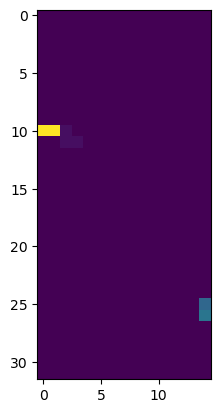

In [272]:
plt.imshow(image7898[700])

In [292]:
with rasterio.open("C:/Users/Richard Omondi/Downloads/future/Bukidnon_precip_predicted_images1.tif") as src:
     # Read the image data
    image72 = src.read()

In [293]:
image72.shape

(798, 12, 9)

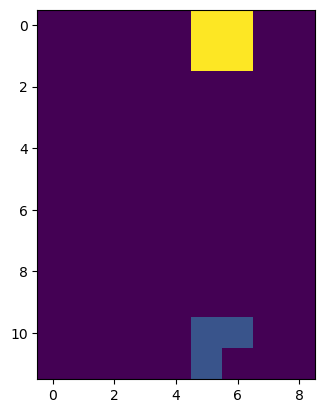

In [294]:
plt.imshow(image72[10])

In [295]:
image72[10]

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        3.6197536 , 3.6183667 , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        3.6180642 , 3.6179032 , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ],


In [296]:
np.amax(image72, axis=(1,2))

array([ 3.6197536,  3.6197536,  3.6197536,  3.6197536,  3.6197536,
        3.6197536,  3.6197536,  3.6197536,  3.6197536,  3.6197536,
        3.6197536,  3.6197536, 66.580505 , 66.580505 , 66.580505 ,
       66.580505 ,  1.0789874,  1.0789874,  1.0789874,  1.0789874,
        1.0789852,  1.0789852,  1.0789852,  1.0789852,  3.6197536,
        3.6197536,  3.6197536,  3.6197536, 66.5805   , 66.5805   ,
       66.5805   , 66.5805   , 66.58051  , 66.58051  , 66.58051  ,
       66.58051  , 66.58049  , 66.58049  , 66.58049  , 66.58049  ,
       66.580505 , 66.580505 , 66.580505 , 66.580505 , 66.580505 ,
       66.580505 , 66.580505 , 66.580505 ,  3.6197536,  3.6197536,
        3.6197536,  3.6197536, 66.58049  , 66.58049  , 66.58049  ,
       66.58049  , 66.58049  , 66.58049  , 66.58049  , 66.58049  ,
       66.58049  , 66.58049  , 66.58049  , 66.58049  ,  3.6197536,
        3.6197536,  3.6197536,  3.6197536, 66.580505 , 66.580505 ,
       66.580505 , 66.580505 ,  3.6197536,  3.6197536,  3.6197

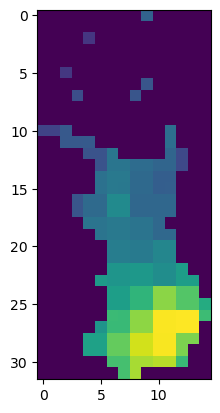

In [251]:
plt.imshow(image7898[15])

In [186]:
image7898[570]*20

array([[ 0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
         0.       ,  0.       ,  0.       ,  0.       ,  7.7691245,
         0.       ,  0.       ,  0.       ,  0.       ,  0.       ],
       [ 0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
         0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
         0.       ,  0.       ,  0.       ,  0.       ,  0.       ],
       [ 0.       ,  0.       ,  0.       ,  0.       ,  3.8768716,
         0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
         0.       ,  0.       ,  0.       ,  0.       ,  0.       ],
       [ 0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
         0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
         0.       ,  0.       ,  0.       ,  0.       ,  0.       ],
       [ 0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
         0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
         0.       ,  0.       ,  0.       , 

In [44]:
za=src.meta
print(za)

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 15, 'height': 13, 'count': 365, 'crs': CRS.from_wkt('GEOGCS["WGS 84",DATUM["World Geodetic System 1984",SPHEROID["WGS 84",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST]]'), 'transform': Affine(0.10000000149011612, 0.0, 37.4500032402575,
       0.0, -0.10384615539358213, -0.40000075101852417)}


In [45]:
len(fi)

365

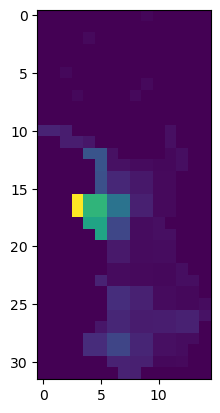

In [72]:
plt.imshow(image[230])

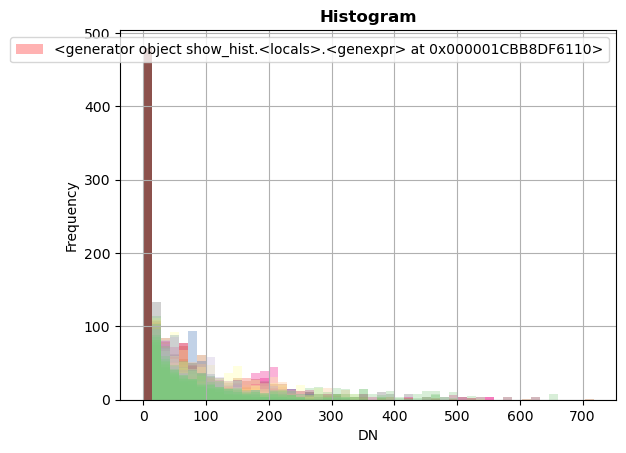

In [71]:
from rasterio.plot import show_hist
show_hist(image, bins=50, lw=0.0, stacked=False, alpha=0.3,
        histtype='stepfilled', title="Histogram")

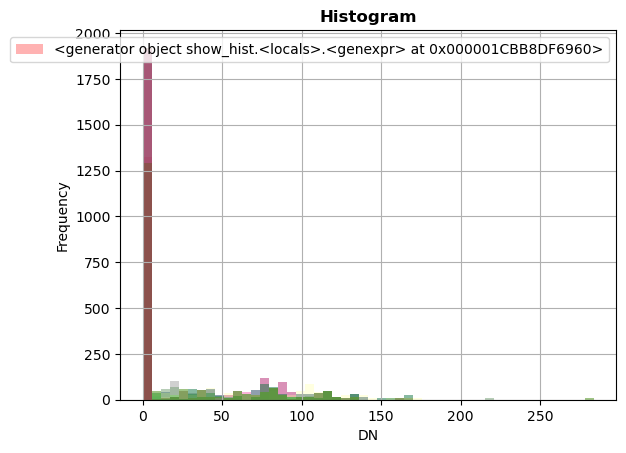

In [67]:
from rasterio.plot import show_hist
show_hist(fi, bins=50, lw=0.0, stacked=False, alpha=0.3,
        histtype='stepfilled', title="Histogram")

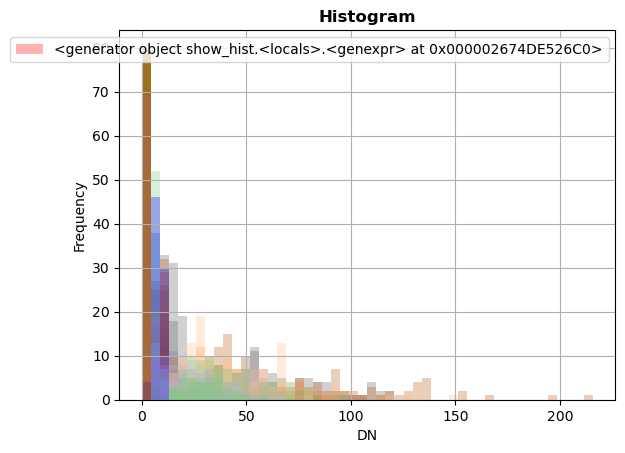

In [47]:
from rasterio.plot import show_hist
show_hist(image2, bins=50, lw=0.0, stacked=False, alpha=0.3,
        histtype='stepfilled', title="Histogram")

In [48]:
last_image = X_test[-365:]*255

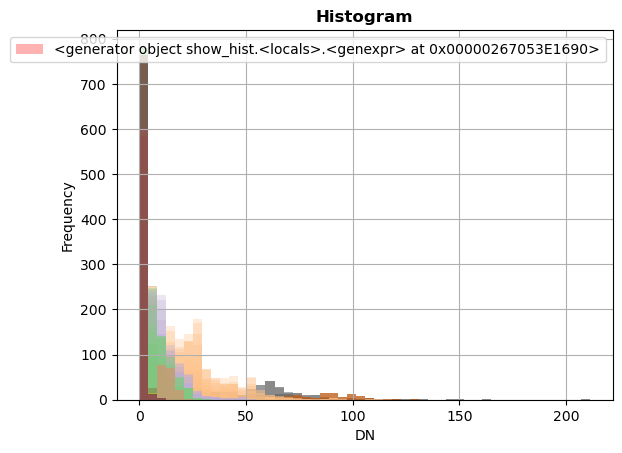

In [49]:
from rasterio.plot import show_hist
show_hist(last_image, bins=50, lw=0.0, stacked=False, alpha=0.3,
        histtype='stepfilled', title="Histogram")

In [62]:
import numpy as np

# Three example datasets
dataset1 = f11_imputed
dataset2 = f22
dataset3 = f33

# Calculate statistical measures
mean1 = np.mean(dataset1)
mean2 = np.mean(dataset2)
mean3 = np.mean(dataset3)

median1 = np.median(dataset1)
median2 = np.median(dataset2)
median3 = np.median(dataset3)

std1 = np.std(dataset1)
std2 = np.std(dataset2)
std3 = np.std(dataset3)

# Calculate Root Mean Squared Error (RMSE)
rmse1 = np.sqrt(np.mean((np.array(dataset1) - mean1) ** 2))
rmse2 = np.sqrt(np.mean((np.array(dataset2) - mean2) ** 2))
rmse3 = np.sqrt(np.mean((np.array(dataset3) - mean3) ** 2))

# Print the results
print("Dataset 1 - Mean:", mean1, "Median:", median1, "Standard Deviation:", std1, "RMSE:", rmse1)
print("Dataset 2 - Mean:", mean2, "Median:", median2, "Standard Deviation:", std2, "RMSE:", rmse2)
print("Dataset 3 - Mean:", mean3, "Median:", median3, "Standard Deviation:", std3, "RMSE:", rmse3)


Dataset 1 - Mean: 2.38734 Median: 0.0 Standard Deviation: 10.515131 RMSE: 10.515131
Dataset 2 - Mean: 0.5383025572440555 Median: 0.0 Standard Deviation: 10.853232692820576 RMSE: 10.853232692820576
Dataset 3 - Mean: 2.204638657395244 Median: 0.0 Standard Deviation: 7.980236845863988 RMSE: 7.980236845863988


In [51]:
fi.shape

(365, 4, 13, 15)

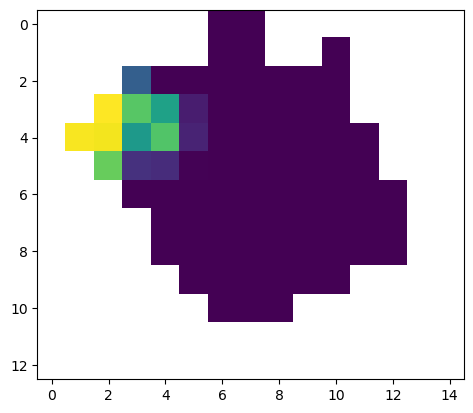

In [52]:
plt.imshow(image2[304])

In [53]:
sequences1 = stack_images_to_seq(image2,sequence_length)

In [54]:
X1 = sequences1[:,:-1]

In [55]:
X1.shape

(361, 4, 13, 15)

In [56]:
f1=X1
f2=fi[:361]
f3=last_image[:361]

In [57]:
f11 = f1.reshape(f1.shape[0],f1.shape[1]*f1.shape[2]*f1.shape[3])
f22 = f2.reshape(f2.shape[0],f2.shape[1]*f2.shape[2]*f2.shape[3])
f33 = f3.reshape(f3.shape[0],f3.shape[1]*f3.shape[2]*f3.shape[3])

In [58]:
f11.shape

(361, 780)

In [59]:
from sklearn.impute import SimpleImputer

# Create an instance of SimpleImputer
imputer = SimpleImputer(strategy='mean')  # You can choose a different strategy if desired (e.g., median, most_frequent)

# Fit the imputer on your data
imputer.fit(f11)

# Impute the NaN values
f11_imputed = imputer.transform(f11)

In [60]:
f11_imputed

array([[0.       , 0.       , 0.       , ..., 8.096258 , 3.8467705,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [8.141294 , 8.887122 , 8.565479 , ..., 0.       , 0.       ,
        0.       ],
       ...,
       [0.       , 0.       , 0.       , ..., 7.432103 , 7.19163  ,
        1.0078039],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ]], dtype=float32)

c:\Users\Richard Omondi\anaconda3\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\Richard Omondi\anaconda3\lib\site-packages\numpy\lib\function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


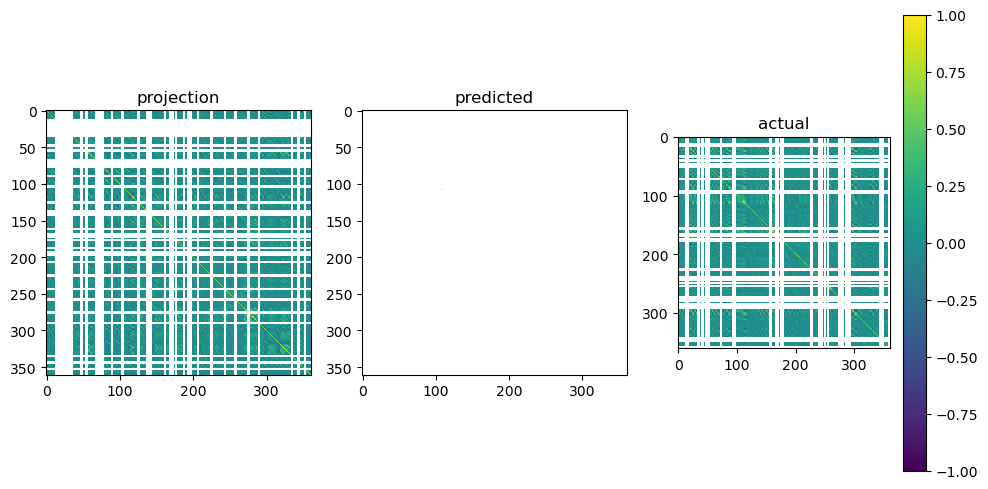

In [61]:
#correlate
corr_matrix1 = np.corrcoef(f11_imputed)
corr_matrix2 = np.corrcoef(f22)
corr_matrix3 = np.corrcoef(f33)

plt.figure(figsize=(10, 5))

plt.subplot(131)
plt.imshow(corr_matrix1, vmin=-1, vmax=1)
plt.title('projection')

plt.subplot(132)
plt.imshow(corr_matrix2, vmin=-1, vmax=1)
plt.title('predicted')

plt.subplot(133)
plt.imshow(corr_matrix3,  vmin=-1, vmax=1)
plt.title('actual')

plt.colorbar()
plt.tight_layout()
plt.show()




In [ ]:
f33.shape

(361, 780)

In [ ]:
f22.shape

(361, 780)

In [ ]:
f11.shape

(361, 780)